# Using the Census API in GIS

This notebook explains how to query data from the Census API, and integrate it into a GIS workflow. We'll use a simple example, pulling some data from ACE 5 year estimates to make maps of housing vacancy rates at various scales. 

By the end of this tutorial, you should be able to:
1) Configure and manage a Python environment in ArcGIS Pro.
2) Interpret data, query, and API syntax from the US Census.
3) Import and map data from the Census API.

## Getting started
This was designed to be run as a Jupyter Notebook inside of ArcGIS Pro. To replicate, you can download this notebook, save it to the home folder associated with your `.aprx` project file, and then add the notebook to your project. 

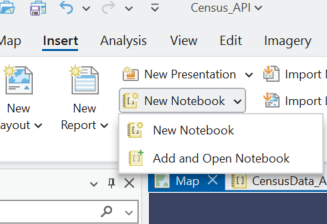

It will now be visible in a newly visible folder called `Notebooks` in the catalog pane. 

In [2]:
# Now load the relevant libraries
import arcpy
from census import Census
import os
import pandas
import geopandas
import requests
import urllib3
import zipfile

Note that you may need to install the `census` library, for using the Census API and providing a directory of FIPS codes respectively. They are not available in the default ArcGIS Python library directory. To do that, you have two options:
1) Open your Python command terminal, and ensure you are working in the right environment. From there, install using the `pip` tool. 

```bash
pip install census
```
2) Use the `! pip install census` notation within the notebook as seen in the code cell below.

Note that if you are running Python in ArcGIS for the first time, you will also need to clone your Python environment and activate the clone. The default Python environment in ArcGIS does not allow installation of new libraries. For details, here's some [ArcGIS documentation](https://pro.arcgis.com/en/pro-app/3.3/arcpy/get-started/clone-an-environment.htm).

In [1]:
! pip install census

In [3]:
# and set up your local working environment
aprx = arcpy.mp.ArcGISProject("Current") # your current aprx file
default_gdb = aprx.defaultGeodatabase  # the default geodatabase of the aprx
default_folder = aprx.homeFolder  # the default folder of the aprx
arcpy.env.overwriteOutput = True  # allows ArcGIS to overwrite files
map = aprx.listMaps()[0] # specify which map you're using 
crs = map.spatialReference  # borrow the default projection from that map

print("Directory: " + default_folder)
print("Geodatabase: " + default_gdb)
print("Activated map: " + map.name)
print("Coordinate reference system: " + crs.name)

Directory: C:\Users\jlauerma\AppData\Local\Temp\ArcGISProTemp17208\Untitled
Geodatabase: C:\Users\jlauerma\AppData\Local\Temp\ArcGISProTemp17208\Untitled\Default.gdb
Activated map: Map
Coordinate reference system: WGS_1984_Web_Mercator_Auxiliary_Sphere


## Understanding the Census API

The US Census Bureau publishes much of its data on via the [Census Data API](https://www.census.gov/data/developers/guidance/api-user-guide.html). If you know what you are looking for, the API is often a more efficient way to query data than by navigating and downloading from the Census website. 

That said, you _really_ need to understand the structure of Census data in order to use the API. So in this section we'll briefly recap Census products, geographies, and structure of content. Remember, you can and should explore data in the [Explore Census Data interface](https://data.census.gov/) first to understand what data to query. 

We'll start by setting up an API call. To get started, you need to obtain a free [Census API key](https://api.census.gov/data/key_signup.html). Save this somewhere secure, and remember not to share it on public platforms (e.g. when you share your code on a portfolio...)

In [4]:
# set API key
API_KEY = "your key here"
c = Census(API_KEY)

#### Data products

Spend some time reviewing the [API Discovery Tool](https://api.census.gov/data.html) for a list of the data products available. Most of the time, we are interested in the demographic, socioeconomic, housing, and employment data from the Decennial Census and American Community Survey. 

The [Decennial Census](https://www.census.gov/programs-surveys/decennial-census.html) has been conducted every decade since 1790. It is the longest and most comprehensive record of American social geography, covering thousands of variables. Like any _census_, it is intended to be a comprehesive account of every person living in the country (though there are well-known issues around enumerating some ["hard-to-count populations"](https://www.census.gov/newsroom/blogs/random-samplings/2023/10/understanding-undercounted-populations.html)).

The [ACS](https://www.census.gov/programs-surveys/acs.html) is a companion to the Decennial Census, run every year since 2005. It includes many of the same variables counted in the Census, available on a more regularly updated basis. But like any _survey_, the ACS counts only a small sample of the overall population (typically about 3.5 million households annually, out of ~127 million households nationally). For this reason ACS data are always published in two forms, an _estimate_ and a _margin of error_. Furthermore, data are aggregated into different temporal estimates:
- _1 year estimates_ use data from only the year in question. They are only available for some variables at the coursest geographic scales.
- _3 year estimates_ use data from the year in question plus the preceding two years (e.g. a 2021-2023 ACS 3 year estimate is an estimate of 2023 values, based on an average of data from 2021 through 2023). They are available for most variables and some finer geographic scales.
- _5 year estimates_ use data from the year in question plus the preceding four years (e.g. a 2019-2023 ACS 3 year estimate is an estimate of 2023 values, based on an average of data from 2019 through 2023). They are available for nearly all variables at nearly all geographic scales. 

In [5]:
# explore metadata
url = "https://api.census.gov/data/2023/acs/acs5/variables.json"  ## variables in 2023 ACS 5 year estimates
response = requests.get(url)  ## pull the URL
variable_list = response.json()  ## create a list of variables

## print a random sample of variables
for i, (var, details) in enumerate(variable_list["variables"].items()):
    if i >= 20:
        break
    print(f"{var}: {details.get('label')}")

for: Census API FIPS 'for' clause
in: Census API FIPS 'in' clause
ucgid: Uniform Census Geography Identifier clause
B24022_060E: Estimate!!Total:!!Female:!!Service occupations:!!Food preparation and serving related occupations
B19001B_014E: Estimate!!Total:!!$100,000 to $124,999
B07007PR_019E: Estimate!!Total:!!Moved from different municipio:!!Foreign born:!!Naturalized U.S. citizen
B19101A_004E: Estimate!!Total:!!$15,000 to $19,999
B24022_061E: Estimate!!Total:!!Female:!!Service occupations:!!Building and grounds cleaning and maintenance occupations
B19001B_013E: Estimate!!Total:!!$75,000 to $99,999
B07007PR_018E: Estimate!!Total:!!Moved from different municipio:!!Foreign born:
B19101A_005E: Estimate!!Total:!!$20,000 to $24,999
B19001B_012E: Estimate!!Total:!!$60,000 to $74,999
B24022_062E: Estimate!!Total:!!Female:!!Service occupations:!!Personal care and service occupations
B01001B_029E: Estimate!!Total:!!Female:!!65 to 74 years
B20005A_021E: Estimate!!Total:!!Male:!!Worked full-tim

Once you know the identifier of the variable(s) you want, we can configure an API call. I'm going to request data on vacant housing units (`B25002_003E`), and to calcualte a vacancy rate I'll also need total number of housing units (`B25002_001E`).  

Remember that Census/ACS data come packaged in numerous geographic scales, each identified with nesting FIPS codes. See the Census [_Geographic Areas Reference Manual_](https://www2.census.gov/geo/pdfs/reference/GARM/) for all the technical details.  There is a different `census` tool for each geography for example:
- States: There are 50 of them, covering the entire US. The call is `.state(fields, state_fips)`
- Counties: There are 3007 of them, nested within states. The call is `state_county(fields, state_fips, county_fips)`
- Tracts: Each tract is a statistical area home to somewhere between 2500-8000 residents. They describe what the census  considers to be a relatively meaningful population area based on demographic, economic, and housing characteristics. Their geographic size is inversely proportional to their population density, so they will be small in cities and larger in rural areas. They are nested within counties, which are nested within states. The call is `state_count_tract(fields, state_fips, county_fips, tract)`
- Block groups: Each block group is a subdivision of a tract, home to between 600-3000 people. This is generally the finest scale of aggregation available for ACS data due to survey limitations and data privacy concerns. The call is `state_county_blockgroup(fields, state_fips, county_fips, blockgroup)`

In [6]:
#define variables
variables = ('B25002_001E', 'B25002_003E')

# pulling data for a single state (in this case, New York)
data = c.acs5.state(fields = variables,  ## note you could also list them here, for example fields = (B25002_001E', B25002_003E')
                     state_fips="36",
                     year = 2023)

# now format as a data frame
data = pandas.DataFrame(data)
data

,B25002_001E,B25002_003E,state
0,8539536.0,870580.0,36


In [7]:
# now for every county within a state
data = c.acs5.state_county(fields = variables,
                           state_fips='36',
                           county_fips = "*",  ## note you could name a specific list of FIPS codes, or use "*" to request all of them
                           year = 2023)
data = pandas.DataFrame(data)
data

,B25002_001E,B25002_003E,state,county
0,146959.0,14231.0,36,001
1,23538.0,6481.0,36,003
2,553231.0,23164.0,36,005
3,92889.0,11108.0,36,007
4,40279.0,8457.0,36,009
...,...,...,...,...
57,29111.0,4857.0,36,115
58,42375.0,4153.0,36,117
59,391861.0,21605.0,36,119
60,18204.0,1941.0,36,121


In [8]:
# now for every tract within every county within a state
data = c.acs5.state_county_tract(fields = variables,
                           state_fips='36',
                           county_fips = "*",  
                           tract = "*",   ## note you could name a specific list of FIPS codes, or use "*" to request all of them
                           year = 2023)
data = pandas.DataFrame(data)
data

,B25002_001E,B25002_003E,state,county,tract
0,940.0,162.0,36,001,000100
1,1674.0,485.0,36,001,000201
2,1271.0,74.0,36,001,000202
3,1573.0,604.0,36,001,000301
4,2213.0,377.0,36,001,000302
...,...,...,...,...,...
5391,1475.0,425.0,36,123,150301
5392,1406.0,557.0,36,123,150302
5393,2079.0,841.0,36,123,150400
5394,1038.0,84.0,36,123,150501


In [9]:
# some quick cleanup with pandas
## rename variables
data = data.rename(columns={
    'B25002_001E':'Total',
    'B25002_003E':'Vacant'})

## create a vacancy rate column
data['Vacancy'] = (data['Vacant'] / data['Total']) * 100

## create a GEOID by concatenating state, county, and tract fips codes
data["GEOID"] = data["state"] + data["county"] + data["tract"]

data

,Total,Vacant,state,county,tract,Vacancy,GEOID
0,940.0,162.0,36,001,000100,17.234043,36001000100
1,1674.0,485.0,36,001,000201,28.972521,36001000201
2,1271.0,74.0,36,001,000202,5.822187,36001000202
3,1573.0,604.0,36,001,000301,38.397966,36001000301
4,2213.0,377.0,36,001,000302,17.035698,36001000302
...,...,...,...,...,...,...,...
5391,1475.0,425.0,36,123,150301,28.813559,36123150301
5392,1406.0,557.0,36,123,150302,39.615932,36123150302
5393,2079.0,841.0,36,123,150400,40.452140,36123150400
5394,1038.0,84.0,36,123,150501,8.092486,36123150501


## Adding boundary layers

Now that we have tabular data, this section explores how to load and join boundary layers. We'll use the `requests` library to query a url for data from the [Census TIGER/Line](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) boundary files. 

In [10]:
# basic set up for loading the file
url = "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_36_tract.zip"
filename = "tl_2023_36_tract.zip"

zip_path = os.path.join(default_folder, filename)

print(f"Download will come from {url}")
print(f"File will save to {zip_path}")

Download will come from https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_36_tract.zip
File will save to C:\Users\jlauerma\AppData\Local\Temp\ArcGISProTemp17208\Untitled\tl_2023_36_tract.zip


In [11]:
# Now we'll configure requests and download the file

## This will disable an SSL certificate error. Don't use this for all websites. But for a trusted site like the census.gov, it's probably safe. 
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Download
response = requests.get(url, verify=False)
with open(zip_path, "wb") as f:
    f.write(response.content)
print(f"Downloaded {filename}.")

Downloaded tl_2023_36_tract.zip.


In [12]:
# Unzip the shapefile
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(default_folder)
print(f"Unzipped {zip_path}")

Unzipped C:\Users\jlauerma\AppData\Local\Temp\ArcGISProTemp17208\Untitled\tl_2023_36_tract.zip


In [13]:
# load shapefile and check projection
boundaries = geopandas.read_file(zip_path)
print(boundaries.head())

  STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ    NAME  \
0      36      093  033102  36093033102  1400000US36093033102  331.02   
1      36      093  020102  36093020102  1400000US36093020102  201.02   
2      36      093  032504  36093032504  1400000US36093032504  325.04   
3      36      081  003400  36081003400  1400000US36081003400      34   
4      36      081  003900  36081003900  1400000US36081003900      39   

              NAMELSAD  MTFCC FUNCSTAT      ALAND   AWATER     INTPTLAT  \
0  Census Tract 331.02  G5020        S  183329990  3232878  +42.7780248   
1  Census Tract 201.02  G5020        S     854905        0  +42.8295375   
2  Census Tract 325.04  G5020        S   65999125  1264687  +42.9010539   
3      Census Tract 34  G5020        S     213987        0  +40.6847731   
4      Census Tract 39  G5020        S     146970        0  +40.7627994   

       INTPTLON                                           geometry  
0  -074.1727005  POLYGON ((-74.30655 42.7

In [14]:
# join the shapefile with the census data
merged = boundaries.merge(data, on = "GEOID")
merged.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Total,Vacant,state,county,tract,Vacancy
0,36,093,033102,36093033102,1400000US36093033102,331.02,Census Tract 331.02,G5020,S,183329990,3232878,+42.7780248,-074.1727005,"POLYGON ((-74.30655 42.75064, -74.30624 42.751...",2661.0,205.0,36,093,033102,7.703871
1,36,093,020102,36093020102,1400000US36093020102,201.02,Census Tract 201.02,G5020,S,854905,0,+42.8295375,-073.9161408,"POLYGON ((-73.92513 42.82029, -73.9244 42.8214...",1101.0,42.0,36,093,020102,3.814714
2,36,093,032504,36093032504,1400000US36093032504,325.04,Census Tract 325.04,G5020,S,65999125,1264687,+42.9010539,-074.0288936,"POLYGON ((-74.09298 42.95587, -74.08805 42.955...",906.0,44.0,36,093,032504,4.856512
3,36,081,003400,36081003400,1400000US36081003400,34,Census Tract 34,G5020,S,213987,0,+40.6847731,-073.8581871,"POLYGON ((-73.8663 40.68319, -73.86549 40.6834...",752.0,32.0,36,081,003400,4.255319
4,36,081,003900,36081003900,1400000US36081003900,39,Census Tract 39,G5020,S,146970,0,+40.7627994,-073.9409316,"POLYGON ((-73.9433 40.76066, -73.94247 40.7619...",620.0,79.0,36,081,003900,12.741935


In [15]:
# save the new spatial layer
merged.drop(columns = "geometry")  ## ArcGIS freaks out over well-known-text fields because the cells are "too long"
merged.to_file(os.path.join(default_folder, "merged_data.shp")) 
print(f"Saved shapefile to {default_folder}")

Saved shapefile to C:\Users\jlauerma\AppData\Local\Temp\ArcGISProTemp17208\Untitled


In [16]:
# import to your geodatabase
shapefile_path = os.path.join(default_folder, "merged_data.shp")
arcpy.FeatureClassToFeatureClass_conversion(shapefile_path, default_gdb, "data")
print(f"Imported to geodatabase.")

Imported to geodatabase.


## Futher reading
- "census" Developer Guide, https://pypi.org/project/census/
- Chao, Steven, "Accessing Census and ACS Data in Python", in _PyGIS - Open Source Spatial Programming & Remote Sensing_, https://pygis.io/docs/d_access_census.html
- Minn, Michael (2025) "Geospatial Data from the US Census Bureau", https://michaelminn.net/tutorials/gis-census/#python
- US Census Bureau (2025), "Census Data API User Guide", https://www.census.gov/data/developers/guidance/api-user-guide.html